In [1]:
import yaml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib as mpl
# Use the pgf backend (must be done before import pyplot interface)
mpl.use('pgf')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    # "text.usetex": True,     # use inline math for ticks
    # "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [2]:
config_file_dir = "../baselines/config.yaml"
results_dir = "../baselines/results"
figures_dir = "./result-storage"
fair_network_results = os.path.join(figures_dir, "fair-network-results")

In [3]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)

# region
# Making dataset-split and model instances
dataset_str_list = '\n'.join([f'{i}: {dataset_name}' for i, dataset_name in enumerate(dataset_names)])
dataset_name_idx = int(input(f"specify the dataset index:\n{dataset_str_list}\n"))
dataset_key = dataset_names[int(dataset_name_idx)]

model_str_list = '\n'.join([f'{i}: {model_name}' for i, model_name in enumerate(model_classes)])
model_class_idx = int(input(f"specify the model index:\n{model_str_list}\n"))
model_class_name = model_classes[model_class_idx]

dataset_manager = GraphDataManager(data_dir, splits_dir)
dataset = dataset_manager.get_dataset_from_key(dataset_key).data

print(f"dataset = {dataset_key}")
instances = make_dataset_instances(data_dir, splits_dir, models_cache_dir, dataset_key, model_class_name, models_config)

instances_accuracy = [instance["accuracy"] for instance in instances]
print(f"acc={np.mean(instances_accuracy)} +- {np.std(instances_accuracy)}")
best_model_accuracy = np.max(instances_accuracy)

instances_logits = [
    instance["model"].predict(dataset) for instance in instances
]

specify the dataset index:
0: cora_ml
1: pubmed
2: citeseer
3: coauthor_cs
4: coauthor_physics
5: amazon_computers
6: amazon_photo
 0
specify the model index:
0: GCN
1: GAT
2: SAGE
3: MLP
4: APPNPNet
 0


dataset = cora_ml
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644565 +- 0.009074238748131642
acc=0.8231307550644565 +- 0.009074238748131642


In [4]:
calib_fraction = np.round(instances[0]["train_idx"].shape[0] / instances[0]["test_idx"].shape[0], 3)

lambda_vals = np.arange(0, 1.01, 0.01).round(3)
accuracy = np.max(instances_accuracy)
coverage_values = np.arange(start=accuracy.round(2), stop=0.97, step=0.01).round(3)
fixed_neigh_coef = 0.6
selected_coverage = np.round(1 - (1 - best_model_accuracy) / 3, 3)


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}

k_reg_range = np.arange(0, dataset.y.max().cpu().numpy(), 1).astype(int)
penalty_range = np.arange(0, 5.01, 0.01).round(3)

pivot_coverages = np.array([(1 + best_model_accuracy * 2) / 3, (1 + best_model_accuracy) / 2, (2 + best_model_accuracy) / 3]).round(2)

In [5]:
instance_idx = 0
instance = instances[instance_idx]
train_idx, val_idx, test_idx = instance["train_idx"], instance["val_idx"], instance["test_idx"]
model = instance["model"]
accuracy = instance["accuracy"]
logits = instances_logits[instance_idx]

In [6]:
calib_fraction = np.round(instances[0]["train_idx"].shape[0] / instances[0]["test_idx"].shape[0], 3)

best_acc = np.max([instance["accuracy"] for instance in instances])

lambda_vals = np.arange(0, 1.01, 0.05).round(3)
coverage_values = np.arange(start=accuracy.round(2), stop=1.0, step=0.005)
fixed_neigh_coef = 0.6
selected_coverage = np.round(1 - (1 - best_model_accuracy) / 3, 2)


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}

In [7]:
true_mask = F.one_hot(dataset.y[test_idx]).bool()

base_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])
base_scores = base_cp.get_scores_from_logits(logits, test_idx=test_idx)
base_results = base_cp.shuffle_metrics_over_coverage(base_scores, true_mask, coverage_values, metrics_dict=metrics_dict, n_iters=100)

over_lambda_mixing_results = []
over_lambda_accuracy = []
for lambda_val in lambda_vals:
    # Making the CP
    mixed_cp = GraphCP(
        transformation_sequence=base_cp.transformation_sequence + [cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0], n_iters=100)]
    )
    mixed_scores = mixed_cp.get_scores_from_logits(logits, test_idx=test_idx)
    mixed_results = mixed_cp.shuffle_metrics_over_coverage(mixed_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)
    mixed_results["lambda"] = lambda_val
    over_lambda_mixing_results.append(mixed_results)
    over_lambda_accuracy.append({"lambda": lambda_val, "accuracy": accuracy_score(y_true=dataset.y[test_idx].cpu(), y_pred=mixed_scores.argmax(dim=1).cpu())})

over_lambda_mixing_results = pd.concat(over_lambda_mixing_results).reset_index().drop(columns="index")
over_lambda_accuracy = pd.DataFrame(over_lambda_accuracy)

In [8]:
true_mask = F.one_hot(dataset.y[test_idx]).bool()

base_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])
base_scores = base_cp.get_scores_from_logits(logits, test_idx=test_idx)
base_results = base_cp.shuffle_metrics_over_coverage(base_scores, true_mask, coverage_values, metrics_dict=metrics_dict, n_iters=100)

over_lambda_mixing_results = []
over_lambda_accuracy = []
for lambda_val in lambda_vals:
    # Making the CP
    mixed_cp = GraphCP(
        transformation_sequence=base_cp.transformation_sequence + [cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0], n_iters=100)]
    )
    mixed_scores = mixed_cp.get_scores_from_logits(logits, test_idx=test_idx)
    mixed_results = mixed_cp.shuffle_metrics_over_coverage(mixed_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)
    mixed_results["lambda"] = lambda_val
    over_lambda_mixing_results.append(mixed_results)
    over_lambda_accuracy.append({"lambda": lambda_val, "accuracy": accuracy_score(y_true=dataset.y[test_idx].cpu(), y_pred=mixed_scores.argmax(dim=1).cpu())})

over_lambda_mixing_results = pd.concat(over_lambda_mixing_results).reset_index().drop(columns="index")
over_lambda_accuracy = pd.DataFrame(over_lambda_accuracy)

In [9]:
selected_coverage = 0.87

In [10]:
over_lambda_mixing_results.loc[abs(over_lambda_mixing_results["coverage_guarantee"] - selected_coverage) < 0.001]

,attempt,empi_coverage,average_set_size,singleton_hit,coverage_guarantee,lambda
100,0.0,0.817793,1.455976,0.597902,0.87,0.0
101,1.0,0.834887,1.512584,0.596348,0.87,0.0
102,2.0,0.915695,1.995602,0.526418,0.87,0.0
103,3.0,0.882673,1.709520,0.576146,0.87,0.0
104,4.0,0.878011,1.691333,0.576535,0.87,0.0
...,...,...,...,...,...,...
7505,5.0,0.910256,1.586682,0.585470,0.87,1.0
7506,6.0,0.780109,1.180651,0.671717,0.87,1.0
7507,7.0,0.852370,1.318627,0.651515,0.87,1.0
7508,8.0,0.862471,1.350386,0.642191,0.87,1.0


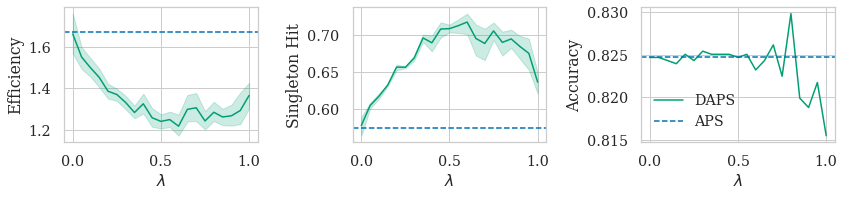

In [11]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.lineplot(data=over_lambda_mixing_results.loc[abs(over_lambda_mixing_results["coverage_guarantee"] - selected_coverage) < 0.001], x="lambda", y="average_set_size", ax=axs[0], label="Mixed", color="#029E73")
axs[0].axhline(base_results.loc[base_results["coverage_guarantee"] == selected_coverage, "average_set_size"].mean(), label="Baseline", color="#0173B2", linestyle="--")
axs[0].set_xlabel("$\lambda$")
axs[0].set_ylabel("Efficiency")
axs[0].legend()

sns.lineplot(data=over_lambda_mixing_results.loc[abs(over_lambda_mixing_results["coverage_guarantee"] - selected_coverage) < 0.001], x="lambda", y="singleton_hit", ax=axs[1], label="Mixed", color="#029E73")
axs[1].axhline(base_results.loc[base_results["coverage_guarantee"] == selected_coverage, "singleton_hit"].mean(), label="Baseline", color="#0173B2", linestyle="--")
axs[1].set_xlabel("$\lambda$")
axs[1].set_ylabel("Singleton Hit")
axs[1].legend()

sns.lineplot(data=over_lambda_accuracy, x="lambda", y="accuracy", ax=axs[2], label="DAPS", color="#029E73")
axs[2].axhline(accuracy,  color="#0173B2", linestyle="--", label="APS")

axs[2].set_ylabel("Accuracy")
axs[2].set_xlabel("$\lambda$")
axs[2].legend(loc="lower left")
axs[0].legend().remove()
axs[1].legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "enhancement-accuracy.pgf"), format="pgf", bbox_inches='tight')


In [12]:
base_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])
base_scores = base_cp.get_scores_from_logits(logits)

selected_coverage = accuracy * 0.34 + 1 * 0.66

mixed_cp = GraphCP(
        transformation_sequence=base_cp.transformation_sequence + [cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0])]
    )
mixed_scores = mixed_cp.get_scores_from_logits(logits)

raps_cp = GraphCP(
    transformation_sequence=base_cp.transformation_sequence + [cp_t.RegularizerPenalty(k_reg=0, penalty=0.1)])
regular_scores = raps_cp.get_scores_from_logits(logits)

In [13]:
def return_class_conditional_coverage(pred_sets, eval_idx):
    result = []
    for selected_class in range((dataset.y.max() + 1).item()):
        class_idxs = (dataset.y[eval_idx] == selected_class).nonzero(as_tuple=True)[0]
        class_coverage_val = pred_sets[class_idxs][:, selected_class].sum() / pred_sets[class_idxs].shape[0] 
        result.append(class_coverage_val.item())
        
    return result

def return_degree_conditional_coverage(eval_idx, pred_sets, eval_mask):
    eval_degrees = degrees[eval_idx]
    result = []
    for selected_degree in range(degrees.max().int().item() + 1):
        degree_coverage = GraphCP.coverage(pred_sets[eval_degrees == selected_degree], eval_mask[eval_degrees == selected_degree])
        result.append(degree_coverage)
    return np.array(result)

In [14]:
degrees = torch_geometric.utils.degree(dataset.edge_index[0], num_nodes=dataset.x.shape[0])

base_cccs = []
base_dccs = []
mixed_cccs = []
mixed_dccs = []
raps_cccs = []
raps_dccs = []
for iteration in range(100):
    calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, true_mask, training_fraction=calib_fraction)

    base_cp.calibrate_from_scores(base_scores[calib_idx], calib_mask)
    mixed_cp.calibrate_from_scores(mixed_scores[calib_idx], calib_mask)
    raps_cp.calibrate_from_scores(regular_scores[calib_idx], calib_mask)

    base_pred_sets = base_cp.predict_from_scores(base_scores[eval_idx])
    mixed_pred_sets = mixed_cp.predict_from_scores(mixed_scores[eval_idx])
    raps_pred_sets = raps_cp.predict_from_scores(regular_scores[eval_idx])
    
    base_cccs.append(return_class_conditional_coverage(base_pred_sets, eval_idx))
    mixed_cccs.append(return_class_conditional_coverage(mixed_pred_sets, eval_idx))
    raps_cccs.append(return_class_conditional_coverage(raps_pred_sets, eval_idx))
    
    base_dccs.append(return_degree_conditional_coverage(eval_idx, base_pred_sets, eval_mask))
    mixed_dccs.append(return_degree_conditional_coverage(eval_idx, mixed_pred_sets, eval_mask))
    raps_dccs.append(return_degree_conditional_coverage(eval_idx, raps_pred_sets, eval_mask))

In [15]:
base_cccs = np.array(base_cccs).mean(axis=0)
mixed_cccs = np.array(mixed_cccs).mean(axis=0)
raps_cccs = np.array(raps_cccs).mean(axis=0)

In [16]:
base_dccs = np.stack(base_dccs).mean(axis=0)
mixed_dccs = np.stack(mixed_dccs).mean(axis=0)
raps_dccs = np.stack(raps_dccs).mean(axis=0)

In [17]:
dss_df = pd.DataFrame()

dss_df["APS"] = base_dccs
dss_df["RAPS"] = raps_dccs
dss_df["DAPS"] = mixed_dccs
dss_df = dss_df.reset_index().rename(columns={"index": "degree"})
dss_df["freq"] = dss_df["degree"].apply(lambda i: (degrees == i).sum().item())
dss_df

,degree,APS,RAPS,DAPS,freq
0,0,NaN,NaN,NaN,0
1,1,0.909580,0.884165,0.841442,587
2,2,0.930672,0.897467,0.889402,524
3,3,0.926191,0.916510,0.912361,422
4,4,0.907880,0.919649,0.927893,320
...,...,...,...,...,...
242,242,NaN,NaN,NaN,0
243,243,NaN,NaN,NaN,0
244,244,NaN,NaN,NaN,0
245,245,NaN,NaN,NaN,0


In [19]:
ranges = [(1, 1), (2, 2), (3, 3), (4, 4), (5, 10), (11, 15), (16,20), (21, 25), (26, 40), (41, degrees.max().int().item() + 1)]

In [20]:
rl, rr = ranges[0]

In [62]:
counts = []
range_aps = []
range_raps = []
range_daps = []
for rr, rl in ranges:
    print(rr, rl)
    range_loc = dss_df.loc[(rr <= dss_df["degree"]) & (dss_df["degree"] <= rl)].fillna(0)
    aps_group_cov = (range_loc["APS"] * range_loc["freq"]).sum() / range_loc["freq"].sum()
    raps_group_cov = (range_loc["RAPS"] * range_loc["freq"]).sum() / range_loc["freq"].sum()
    daps_group_cov = (range_loc["DAPS"] * range_loc["freq"]).sum() / range_loc["freq"].sum()
    range_aps.append(aps_group_cov)
    range_raps.append(raps_group_cov)
    range_daps.append(daps_group_cov)
    counts.append(range_loc["freq"].sum())

1 1
2 2
3 3
4 4
5 10
11 15
16 20
21 25
26 40
41 247


In [51]:
range_aps_df = pd.DataFrame()
range_aps_df["coverage"] = range_aps
range_aps_df["range"] = ranges
range_aps_df

range_raps_df = pd.DataFrame()
range_raps_df["coverage"] = range_raps
range_raps_df["range"] = ranges
range_raps_df

range_daps_df = pd.DataFrame()
range_daps_df["coverage"] = range_daps
range_daps_df["range"] = ranges
final_plot_df = pd.concat([range_aps_df, range_raps_df, range_daps_df], keys=["APS", "RAPS", "DAPS"]).reset_index().rename(columns={"level_0": "method"})
final_plot_df

,method,level_1,coverage,range
0,APS,0,0.909580,"(1, 1)"
1,APS,1,0.930672,"(2, 2)"
2,APS,2,0.926191,"(3, 3)"
3,APS,3,0.907880,"(4, 4)"
4,APS,4,0.891077,"(5, 10)"
5,APS,5,0.883477,"(11, 15)"
6,APS,6,0.915221,"(16, 20)"
7,APS,7,0.801982,"(21, 25)"
8,APS,8,0.813953,"(26, 40)"
9,APS,9,0.059706,"(41, 247)"


In [63]:
counts

[587, 524, 422, 320, 801, 183, 66, 32, 43, 17]

In [ ]:
sns.set_theme(context='notebook', style='whitegrid', palette=sns.color_palette("rocket", 3), font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 1)

axs.bar(range_aps_df.index - 0.2,range_aps_df["coverage"], width=0.2, label="APS", color="#0173B2")
axs.bar(range_aps_df.index ,range_raps_df["coverage"], width=0.2, label="APS", color="#DE8F05")
axs.bar(range_aps_df.index + 0.2,range_daps_df["coverage"], width=0.2, label="APS", color="#029E73")

axs.set_xticklabels(range_aps_df["range"].apply(lambda val: f"{val[0]} - {val[1]}"), rotation=90)

plt.xticks(rotation=90)

plt.savefig(os.path.join(figures_dir, "abs-degree-conditional.pgf"), format="pgf", bbox_inches='tight')

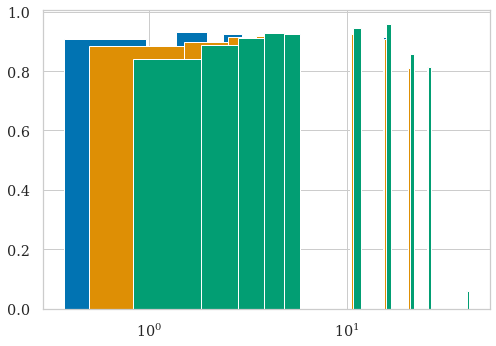

In [42]:
plt.bar(np.array([rl-0.33 for rl, _ in ranges]), np.array(range_aps), width=0.6, label="APS", color="#0173B2")
plt.bar(np.array([rl for rl, _ in ranges]), np.array(range_raps), width=1, label="APS", color="#DE8F05")
plt.bar(np.array([rl+0.33 for rl, _ in ranges]), np.array(range_daps), width=1, label="APS", color="#029E73")
# bar(np.arange(degrees.max().item() + 1) + 0.25, mixed_dccs - range_aps, width=0.6, label="DAPS Enhancement", color="#029E73")
plt.xscale("log")


In [25]:
[rl - 0.25 for _, rl in ranges]

[0.75, 1.75, 2.75, 3.75, 9.75, 14.75, 19.75, 24.75, 39.75, 246.75]

In [ ]:
sns.set_theme(context='notebook', style='whitegrid', palette=sns.color_palette("rocket", 3), font='serif', font_scale=1.3, color_codes=True, rc=None)

f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(np.arange(dataset.y.max().item() + 1) - 0.25, base_cccs, width=0.2, label="APS", color="#0173B2")
axs[0].bar(np.arange(dataset.y.max().item() + 1) , raps_cccs, width=0.2, label="RAPS", color="#DE8F05")
axs[0].bar(np.arange(dataset.y.max().item() + 1) + 0.25, mixed_cccs, width=0.2, label="DAPS", color="#029E73")
axs[0].axhline(base_cp.coverage_guarantee, color="black", linestyle="--")

axs[1].bar(range_aps_df.index - 0.2,range_raps_df["coverage"] - range_aps_df["coverage"], width=0.3, label="APS", color="#DE8F05")
axs[1].bar(range_aps_df.index + 0.2,range_daps_df["coverage"] - range_aps_df["coverage"], width=0.3, label="APS", color="#029E73")

axs[1].set_xticklabels(range_aps_df["range"].apply(lambda val: f"{val[0]} - {val[1]}"), rotation=90)

axs[0].set_ylabel("Coverage")
axs[1].set_ylabel("Coverage Enhancement")
axs[0].set_xlabel("Class")
axs[1].set_xlabel("Degree")


handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend().remove()
axs[1].legend(handles=handles, labels=labels, loc="lower right", )
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "class-and-degree-conditional.pgf"), format="pgf", bbox_inches='tight')

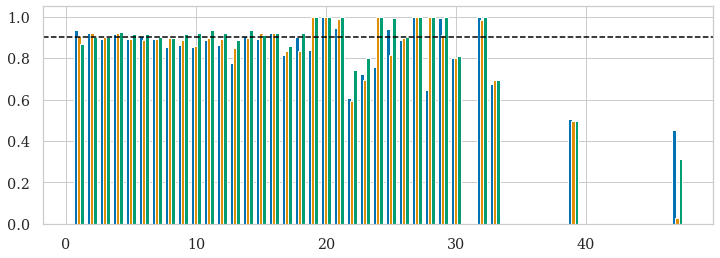

In [70]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(np.arange(degrees.max().item() + 1) - 0.25, base_dccs, width=0.3, label="RAPS Enhancement", color="#0173B2")
ax.bar(np.arange(degrees.max().item() + 1) , raps_dccs, width=0.3, label="RAPS Enhancement", color="#DE8F05")
ax.bar(np.arange(degrees.max().item() + 1) + 0.25, mixed_dccs, width=0.3, label="DAPS Enhancement", color="#029E73")
ax.axhline(base_cp.coverage_guarantee, color="black", linestyle="--")

In [ ]:
plt.bar(np.arange(degrees.max().item() + 1) - 0.25, [(degrees == i).sum().item() for i in range(degrees.max().int().item() + 1)], width=0.3, label="RAPS Enhancement", color="#0173B2")

In [ ]:
[(degrees == i).sum().item() for i in range(degrees.max().int().item() + 1)]